In [2]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from random import sample
import seaborn as sns

from statsmodels import regression
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

plt.rcParams["figure.figsize"] = (15,7)

In [3]:
start = "2016-05-01"
end = "2021-01-01"
samples = ["AM","AR","APA","AROC","BKR","BSM","BP","BPMP","COG","WHD","CPE","CVE","CDEV","CHX","LNG","CQP","CHK","CVX","XEC","CLNE","CNX","CRK","COP","CLR","CEQP","CVI","DCP","DKL","DK","DEN","DVN","FANG","DNOW","ET","DRQ","ENBL","ERF","ENLC","EPD","EOG","EQT","ETRN","XOM","GEL","HAL","HP","HES","HEP","HFC","KMI","KOS","LBRT","MMP","MGY","MRO","MPC","MTDR","MPLX","MUR","NESR","NFG","NOV","NBLX","NS","OAS","OXY","OII","OKE","PTEN","PBF","PDCE","PSX","PSXP","PXD","PAA","PAGP","RRC","RTLR","REGI","RES","SOL","SLB","SHLX","OILY","SM","SWN","SUN","TRGP","FTI","TPL","TGS","WMB","RIG","USAC","VLO","VVV","VET","VNOM","WES","WLL","INT"]
data = yf.download(tickers=samples, start=start, end=end, interval = "1d")
prices = data['Adj Close'].dropna(axis=1)

[*********************100%***********************]  101 of 101 completed

2 Failed downloads:
- DEN: Data doesn't exist for startDate = 1462060800, endDate = 1609459200
- CHK: Data doesn't exist for startDate = 1462060800, endDate = 1609459200


In [ ]:
prices = prices[:785]

In [5]:
oilUS = pd.read_csv('https://raw.githubusercontent.com/LDeng0205/Pairs-Trading-with-Macroeconomic-Data-Analysis/master/oil-data/DCOILWTICO.csv')
oilEU = pd.read_csv('https://raw.githubusercontent.com/LDeng0205/Pairs-Trading-with-Macroeconomic-Data-Analysis/master/oil-data/DCOILBRENTEU.csv')
dgs5 = pd.read_csv('https://raw.githubusercontent.com/LDeng0205/Pairs-Trading-with-Macroeconomic-Data-Analysis/master/oil-data/DGS5.csv')
T5YIE = pd.read_csv('https://raw.githubusercontent.com/LDeng0205/Pairs-Trading-with-Macroeconomic-Data-Analysis/master/oil-data/T5YIE.csv')
# unrate = pd.read_csv('https://raw.githubusercontent.com/LDeng0205/Pairs-Trading-with-Macroeconomic-Data-Analysis/master/oil-data/UNRATE.csv')
# oilUS #daily from 2016 april 19
# oilEU #daily from 2016 april 19
# dgs5 #daily from 2016 april 25
# T5YIE #daily from 2016 april 25
# unrate #monthly from 2016 march 1

def dateAdjust(raw, start_date, end_date):
  mask = (raw['DATE'] >= start_date) & (raw['DATE'] < end_date)
  return raw.loc[mask]

def clean(a, ticker):
  a[a == "."] = '0'
  a[ticker] = a[ticker].astype("float64")
  a.DATE = pd.to_datetime(a.DATE)
  clean = a.set_index(["DATE"])
  clean_resampled = clean.resample("1d").interpolate()
  return clean_resampled[ticker]



oilUS = dateAdjust(oilUS, start, end)
oilEU = dateAdjust(oilEU, start, end)
dgs5 = dateAdjust(dgs5, start, end)
T5YIE = dateAdjust(T5YIE, start, end)
# unrate = dateAdjust(unrate, start, end)


a1 = clean(oilUS,"DCOILWTICO").to_numpy()
a2 = clean(oilEU,"DCOILBRENTEU").to_numpy()
a3 = clean(dgs5,"DGS5").to_numpy()
a4 = clean(T5YIE,"T5YIE").to_numpy()
const = np.ones_like(a1, dtype = 'float64')

A = np.vstack((a1, a2, a3, a4, const)).T
train_len = int(len(A) * 2/3)
A = A[:train_len]

#A, containing information about macroeconomic data, is the matrix for least squares
#least squares equation A * Wn = Pn
#where p is the stock price time series of the company
print(A.shape)

print(len(data))
resampled_data = prices.resample("1d").interpolate().to_numpy()
resampled_data = resampled_data[:train_len]
print(resampled_data.shape)


(1136, 5)
1177
(1136, 88)


In [6]:
# finds weights that give least-square error
# matrix equation: A*weights ~ data
weights = np.matmul(np.linalg.pinv(A),resampled_data).T
print(weights.shape)
print(resampled_data.shape)

# normalize the weights
n = len(weights)
for i in range(n):
  weights[i] = weights[i]/np.linalg.norm(weights[i])

# x is the min value of inner product required to identify as pair
x = .99
results = []
macro_pairs = []
for i in range(n):
  for j in range(min(i + 1, n - 1), n):
    if (np.dot(weights[i], weights[j])>x):
      results.append((samples[i], samples[j]))
      # results.append((i, j))
      macro_pairs.append([i,j])
print(results)
print(len(results))
# print(weights)

(88, 5)
(1136, 88)
[('AM', 'AROC'), ('AM', 'CHX'), ('AM', 'CHK'), ('AM', 'COP'), ('AM', 'CLR'), ('AM', 'DEN'), ('AM', 'ENBL'), ('AM', 'EQT'), ('AM', 'MMP'), ('AM', 'MGY'), ('AM', 'MRO'), ('AM', 'NOV'), ('AM', 'OKE'), ('AM', 'PDCE'), ('AM', 'PSX'), ('AM', 'SUN'), ('AR', 'DEN'), ('AR', 'MMP'), ('AR', 'MGY'), ('AR', 'NOV'), ('AR', 'OAS'), ('AR', 'PBF'), ('AR', 'PAGP'), ('APA', 'CPE'), ('APA', 'ERF'), ('APA', 'ETRN'), ('APA', 'HAL'), ('APA', 'LBRT'), ('APA', 'MUR'), ('APA', 'NESR'), ('APA', 'OXY'), ('APA', 'SM'), ('APA', 'TRGP'), ('AROC', 'CHX'), ('AROC', 'CLR'), ('AROC', 'DEN'), ('AROC', 'ENBL'), ('AROC', 'EQT'), ('AROC', 'MMP'), ('AROC', 'MGY'), ('AROC', 'MRO'), ('AROC', 'NOV'), ('AROC', 'OAS'), ('AROC', 'OKE'), ('AROC', 'PDCE'), ('AROC', 'PSX'), ('AROC', 'SUN'), ('BKR', 'LNG'), ('BKR', 'DVN'), ('BKR', 'GEL'), ('BKR', 'HEP'), ('BKR', 'MTDR'), ('BKR', 'NBLX'), ('BSM', 'XEC'), ('BSM', 'CLNE'), ('BSM', 'CRK'), ('BSM', 'CVI'), ('BSM', 'DKL'), ('BSM', 'DK'), ('BSM', 'DNOW'), ('BSM', 'ENLC'), 

In [7]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j],pvalue))
    return score_matrix, pvalue_matrix, pairs

In [20]:
scores, pvalues, pairs, = find_cointegrated_pairs(prices[:785])
best_pairs = [pair for pair in pairs if pair[2]<.001]

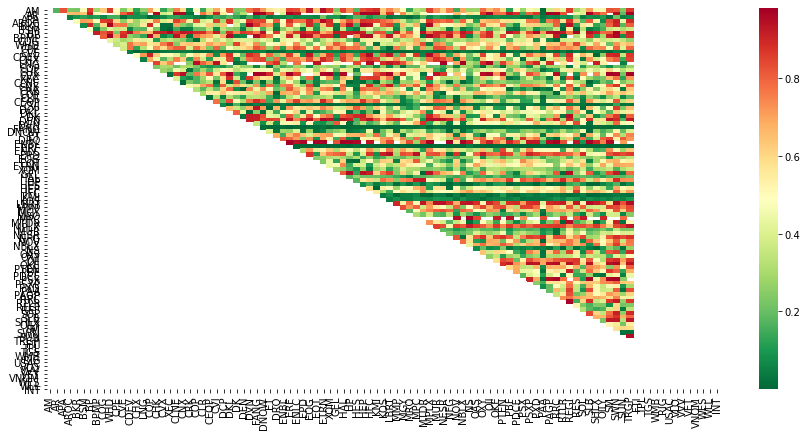

In [21]:
sns.heatmap(pvalues, xticklabels=samples, yticklabels=samples, cmap='RdYlGn_r' , mask = (pvalues >= 0.98))
plt.show()

In [22]:
data = yf.download(tickers=samples, start=start, end=end, interval = "1d")
prices = data['Adj Close'].dropna(axis=1)

[*********************100%***********************]  101 of 101 completed

2 Failed downloads:
- DEN: Data doesn't exist for startDate = 1462060800, endDate = 1609459200
- CHK: Data doesn't exist for startDate = 1462060800, endDate = 1609459200


In [12]:
# ticker1 = "AROC"# Set ticker1
# ticker2 = "CPE"# Set ticker2
# S1 = prices[ticker1]
# S2 = prices[ticker2]
# score, pvalue, _ = coint(S1, S2)
# print(pvalue)

# ratios = S1 / S2
# #ratios.plot(figsize=(15,7))
# #plt.axhline(ratios.mean())
# #plt.legend(['Price Ratio'])
# #plt.show()

0.02142669049384512


In [13]:
pairs

[('APA', 'CPE', 0.010301785575466904),
 ('APA', 'OII', 0.00939392506068991),
 ('APA', 'OILY', 0.033782475260515914),
 ('APA', 'PDCE', 0.030232837659505442),
 ('APA', 'PTEN', 0.03862262359172787),
 ('APA', 'SLB', 0.044307156377063825),
 ('APA', 'SUN', 0.026073880999326386),
 ('AR', 'SUN', 0.02801091942040402),
 ('AROC', 'BKR', 0.007214824536592134),
 ('AROC', 'BSM', 0.046089816956134746),
 ('AROC', 'CDEV', 0.029223491621669883),
 ('AROC', 'CPE', 0.02142669049384512),
 ('AROC', 'CRK', 0.034757977264275756),
 ('AROC', 'CVE', 0.011263283943664737),
 ('AROC', 'DCP', 0.015809456756876752),
 ('AROC', 'DNOW', 0.031769455769527756),
 ('AROC', 'DVN', 0.031147776110392208),
 ('AROC', 'ENBL', 0.030300800985109712),
 ('AROC', 'ENLC', 0.03597624652699385),
 ('AROC', 'FTI', 0.023190072048646763),
 ('AROC', 'HAL', 0.04303450118598282),
 ('AROC', 'HEP', 0.0327011810873617),
 ('AROC', 'KOS', 0.029443930391680015),
 ('AROC', 'MMP', 0.030198840547191713),
 ('AROC', 'NFG', 0.031502273135641044),
 ('AROC', 

In [23]:
trimmed_pairs = [(pair[0], pair[1]) for pair in pairs]
#trimmed_pairs
combo_pairs = []
for result in results:
    if ((result[0],result[1]) in trimmed_pairs) or ((result[1], result[0]) in trimmed_pairs):
        combo_pairs.append(result)
combo_pairs

[('AROC', 'MMP'),
 ('AROC', 'NOV'),
 ('AROC', 'OAS'),
 ('AROC', 'PDCE'),
 ('AROC', 'SUN'),
 ('BSM', 'CVI'),
 ('BSM', 'DKL'),
 ('BSM', 'DK'),
 ('BSM', 'MPLX'),
 ('COG', 'COP'),
 ('COG', 'PSXP'),
 ('LNG', 'HEP'),
 ('XEC', 'DKL'),
 ('XEC', 'MPLX'),
 ('CLNE', 'DNOW'),
 ('DKL', 'MPLX'),
 ('FANG', 'EOG'),
 ('FANG', 'HFC'),
 ('FANG', 'NS'),
 ('ET', 'PTEN'),
 ('ET', 'SOL'),
 ('ET', 'OILY'),
 ('DRQ', 'PDCE'),
 ('ENBL', 'EQT'),
 ('ENBL', 'MMP'),
 ('ENBL', 'MRO'),
 ('ENBL', 'OKE'),
 ('ENBL', 'PSX'),
 ('ENBL', 'SOL'),
 ('ENBL', 'SUN'),
 ('ERF', 'EOG'),
 ('HEP', 'MTDR'),
 ('MUR', 'OXY'),
 ('MUR', 'TRGP'),
 ('NFG', 'OII'),
 ('NFG', 'SLB'),
 ('OAS', 'SUN'),
 ('PDCE', 'SUN')]

In [24]:
split_number = round(2/3 * len(ratios))
print(split_number)
train = ratios[:split_number]
test = ratios[split_number:]

785


In [35]:
total_profit = 0

stock_price_avg_new = 0

for pair in combo_pairs:
    ticker1 = pair[0]
    ticker2 = pair[1]
    stock_price_avg_new += sum(prices[ticker1].iloc[split_number:]) + sum(prices[ticker2].iloc[split_number:])
    total_profit += trade(prices[ticker1].iloc[split_number:], prices[ticker2].iloc[split_number:], 5, 45)

old_profit = 0
stock_price_avg_old = 0

for pair in pairs:
    ticker1 = pair[0]
    ticker2 = pair[1]
    stock_price_avg_old += sum(prices[ticker1].iloc[split_number:]) + sum(prices[ticker2].iloc[split_number:])
    old_profit += trade(prices[ticker1].iloc[split_number:], prices[ticker2].iloc[split_number:], 5, 45)

stock_price_avg_old /= len(pairs) * 392
stock_price_avg_new /= len(combo_pairs) * 392
average_old = old_profit/len(pairs)
print('# of pairs selected without macro (original): ', len(pairs))
print('avg share price of stock from original pairs over test set period: ', stock_price_avg_old)
print('total profit generated: ', old_profit)
print('average profit per pair: ', average_old)
print('=================')
#total_profit
print('# of pairs selected with macro (combo pairs): ', len(combo_pairs))
print('avg share price of stock from combopairs over test set period: ',stock_price_avg_new)
print('total profit generated: ', total_profit)
print('average profit per pair: ', average_profit)


# of pairs selected without macro (original):  483
avg share price of stock from original pairs over test set period:  61.32497481093196
total profit generated:  257185.5151310004
average profit per pair:  532.475186606626
# of pairs selected with macro (combo pairs):  38
avg share price of stock from combopairs over test set period:  43.26493484387724
total profit generated:  62949.37760061994
average profit per pair:  1656.562568437367


In [ ]:
ticker1 = "DKL"# Set ticker1
ticker2 = "MRO"

In [ ]:
# Compute the rolling z-score of the ratio using the definition above
# Hint: Use pandas.Series.rolling on your training set. Set center = false

ratios_mavg5 = ratios.rolling('5d',center = False).mean() 
# print(ratios_mavg5)

ratios_mavg60 = ratios.rolling('60d',center = False).mean() 
# print(ratios_mavg60)

std_60 = ratios.rolling('60d',center = False).std()
# print(std_60)

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
print(zscore_60_5)

Date
2016-05-02         NaN
2016-05-03    0.000000
2016-05-04    0.000000
2016-05-05    0.000000
2016-05-06    0.000000
                ...   
2020-12-24   -1.123201
2020-12-28   -1.024613
2020-12-29   -0.926152
2020-12-30   -0.932872
2020-12-31   -0.896293
Length: 1177, dtype: float64


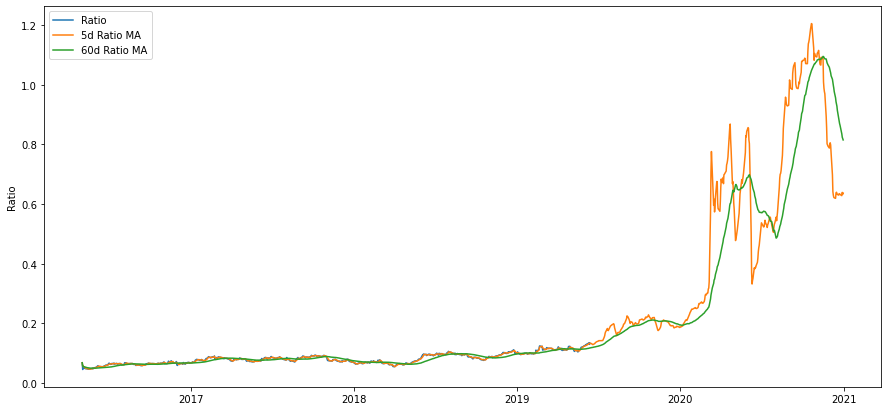

In [ ]:
# This plots the moving averages you calculated. Notice how longer windows smoothen out the curves.

plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

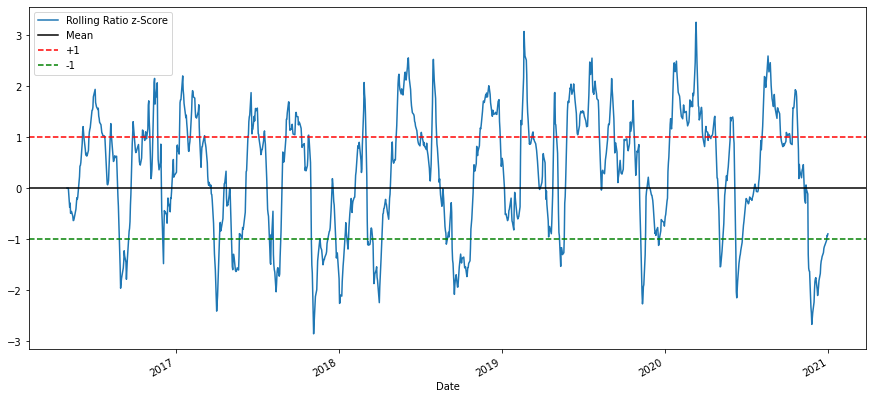

In [ ]:
# This plot the rolling z-score of the ratio

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

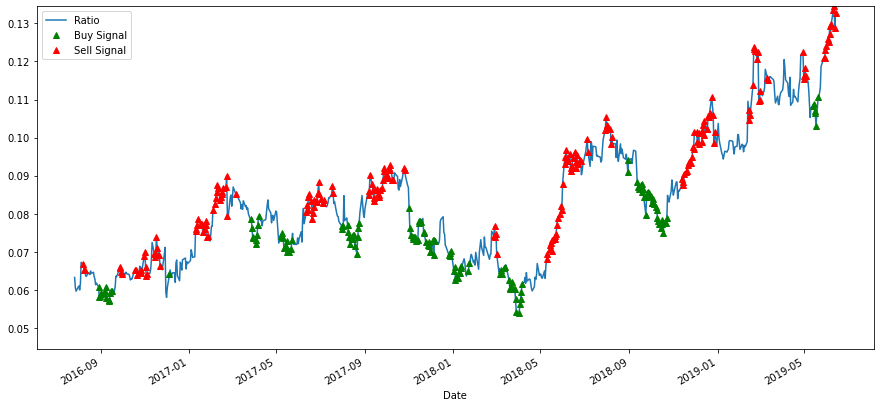

In [ ]:
#Generate signals using the previously defined trading strategy

plt.figure(figsize=(15,7))
train[60:].plot()

buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0 
sell[zscore_60_5<1] = 0

buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,train.min(),train.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

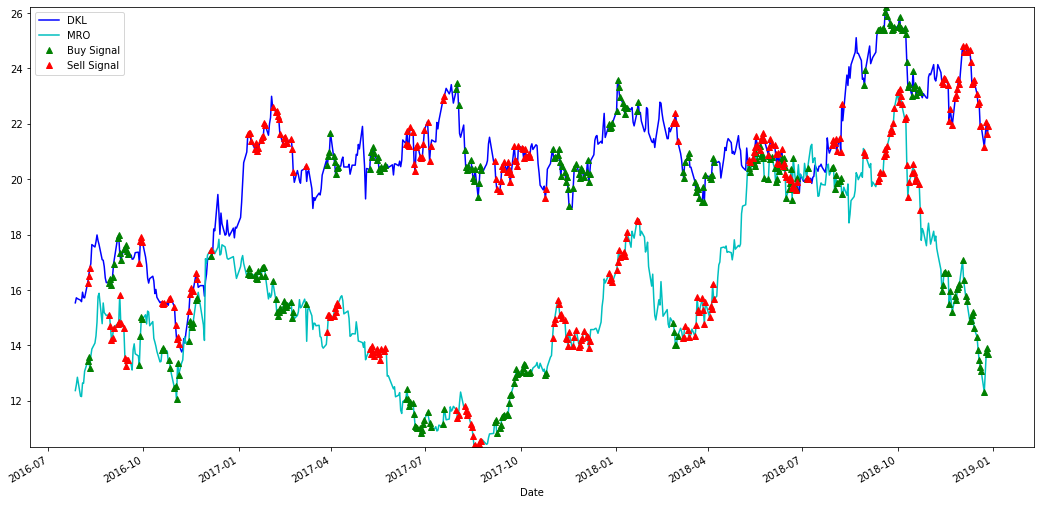

In [ ]:
plt.figure(figsize=(18,9))
S1 = prices[ticker1].iloc[:671]
S2 = prices[ticker2].iloc[:671]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend([ticker1,ticker2, 'Buy Signal', 'Sell Signal'])
plt.show()

In [17]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

In [ ]:
trade(prices[ticker1].iloc[:split_number], prices[ticker2].iloc[:split_number], 5, 60)

572.0126038583683

In [ ]:
trade(prices[ticker1].iloc[split_number:], prices[ticker2].iloc[split_number:], 5, 60)


211.55338707654852

In [ ]:
# Check with training data
length_scores = [trade(prices[ticker1].iloc[:split_number], 
                prices[ticker2].iloc[:split_number], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)
print('Money made:', length_scores[best_length])

Best window length: 243
Money made: 1343.829915482922


In [ ]:
# Check with testing data
length_scores2 = [trade(prices[ticker1].iloc[split_number:], 
                  prices[ticker2].iloc[split_number:],5, l) 
                  for l in range(255)]

best_length2 = np.argmax(length_scores2)
print ('Best window length:', best_length2)
print('Money made:', length_scores2[best_length2])

Best window length: 136
Money made: 1111.3386710529294
